In [ ]:
import numpy as np
from scipy.optimize import curve_fit

# Constants for your SS316L / Hematite system
RHO_OX = 5.24    # Fe2O3 density
RHO_SS = 8.00    # SS316L density
A = 4.0          # Constant for nm scale
N = 1.6          # Makhov exponent
S_BULK_STEEL = 0.52  # Your provided value

def theoretical_S_curve(E, d_ox, S_surf):
    """
    Simplified model: Weighting S by the fraction of positrons 
    stopping in the oxide vs. the steel.
    """
    # 1. Calculate Mean Depth for this E
    mass_capacity = A * (E**N)
    oxide_mass_limit = RHO_OX * d_ox * 0.1
    
    # 2. Fraction of positrons in the oxide layer (Integrated Makhov)
    # We use the cumulative distribution function (CDF) of the Makhov profile
    # m=2 shape parameter is standard
    xi_0 = (A * E**N) / 0.886
    fraction_oxide = 1 - np.exp(-(oxide_mass_limit / xi_0)**2)
    
    # 3. Calculated S is the weighted average
    return (fraction_oxide * S_surf) + ((1 - fraction_oxide) * S_BULK_STEEL)

def solve_for_thickness(energies, exp_s_values):
    """
    Fits the theoretical curve to your experimental data to find d_ox
    """
    # Initial guesses: thickness = 20nm, Surface S = 0.54
    popt, pcov = curve_fit(theoretical_S_curve, energies, exp_s_values, p0=[20, 0.54])
    
    fit_d, fit_S_surf = popt
    return fit_d, fit_S_surf

--- SOLVER RESULTS ---
Calculated Thickness: 155.47 nm
Calculated Oxide S:   0.5748


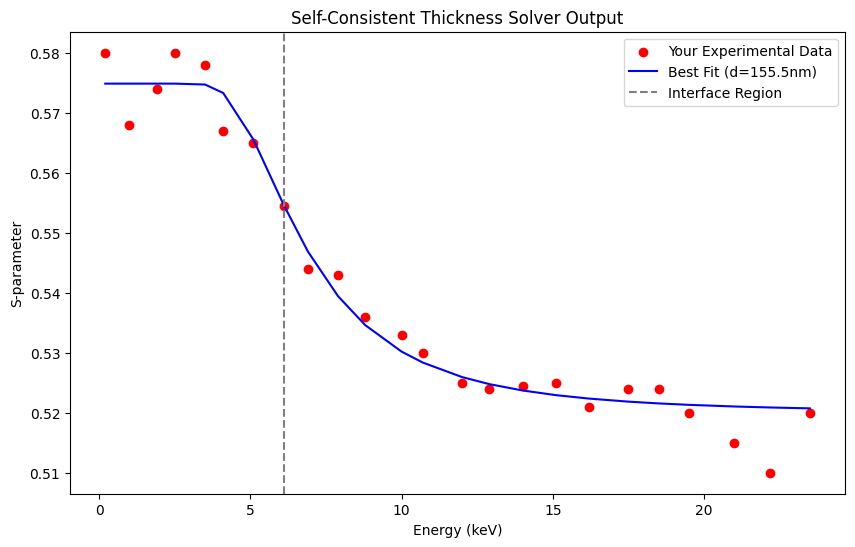

In [16]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1. Your Data
data = np.array([
    [0.2, 0.58], [1.0, 0.568], [1.9, 0.574], [2.5, 0.58], [3.5, 0.578],
    [4.1, 0.5670], [5.1, 0.5650], [6.1, 0.5545], [6.9, 0.5440], [7.9, 0.5430],
    [8.8, 0.5360], [10.0, 0.5330], [10.7, 0.5300], [12.0, 0.5250], [12.9, 0.5240],
    [14.0, 0.5245], [15.1, 0.5250], [16.2, 0.5210], [17.5, 0.5240], [18.5, 0.5240],
    [19.5, 0.5200], [21.0, 0.5150], [22.2, 0.5100], [23.5, 0.5200]
])

# Swapping columns to match (Energy, S) logic
energies = data[:, 0]
s_experimental = data[:, 1]

# 2. Model Parameters
RHO_OX = 5.24
RHO_SS = 8.00
S_BULK_STEEL = 0.520 # Your specified value
A, N = 4.0, 1.6

def fit_model(E, d_ox, S_ox):
    """
    Simplified Weighting Model
    F(E) = Fraction of positrons annihilating in the oxide
    """
    # Mass capacity of the beam at energy E
    mass_capacity = A * (E**N)
    # Mass thickness of the oxide layer
    oxide_mass_limit = RHO_OX * d_ox * 0.1 
    
    # Characteristic mass depth (m=2 Makhov)
    xi_0 = mass_capacity / 0.886
    
    # Fraction of positrons stopping in the first layer
    # CDF of Makhov: 1 - exp(-(xi/xi_0)**2)
    f_ox = 1 - np.exp(-(oxide_mass_limit / xi_0)**2)
    
    return f_ox * S_ox + (1 - f_ox) * S_BULK_STEEL

# 3. Run the Solver
# Initial guess: 15nm thickness, 0.58 surface S
popt, pcov = curve_fit(fit_model, energies, s_experimental, p0=[15, 0.58])

fit_d, fit_S_ox = popt
print(f"--- SOLVER RESULTS ---")
print(f"Calculated Thickness: {fit_d:.2f} nm")
print(f"Calculated Oxide S:   {fit_S_ox:.4f}")

# 4. Visualize the Fit
plt.figure(figsize=(10, 6))
plt.scatter(energies, s_experimental, color='red', label='Your Experimental Data')
plt.plot(energies, fit_model(energies, *popt), 'b-', label=f'Best Fit (d={fit_d:.1f}nm)')
plt.axvline(x=energies[np.argmin(np.abs(s_experimental-0.55))], color='gray', linestyle='--', label='Interface Region')
plt.xlabel('Energy (keV)')
plt.ylabel('S-parameter')
plt.legend()
plt.title('Self-Consistent Thickness Solver Output')
plt.show()

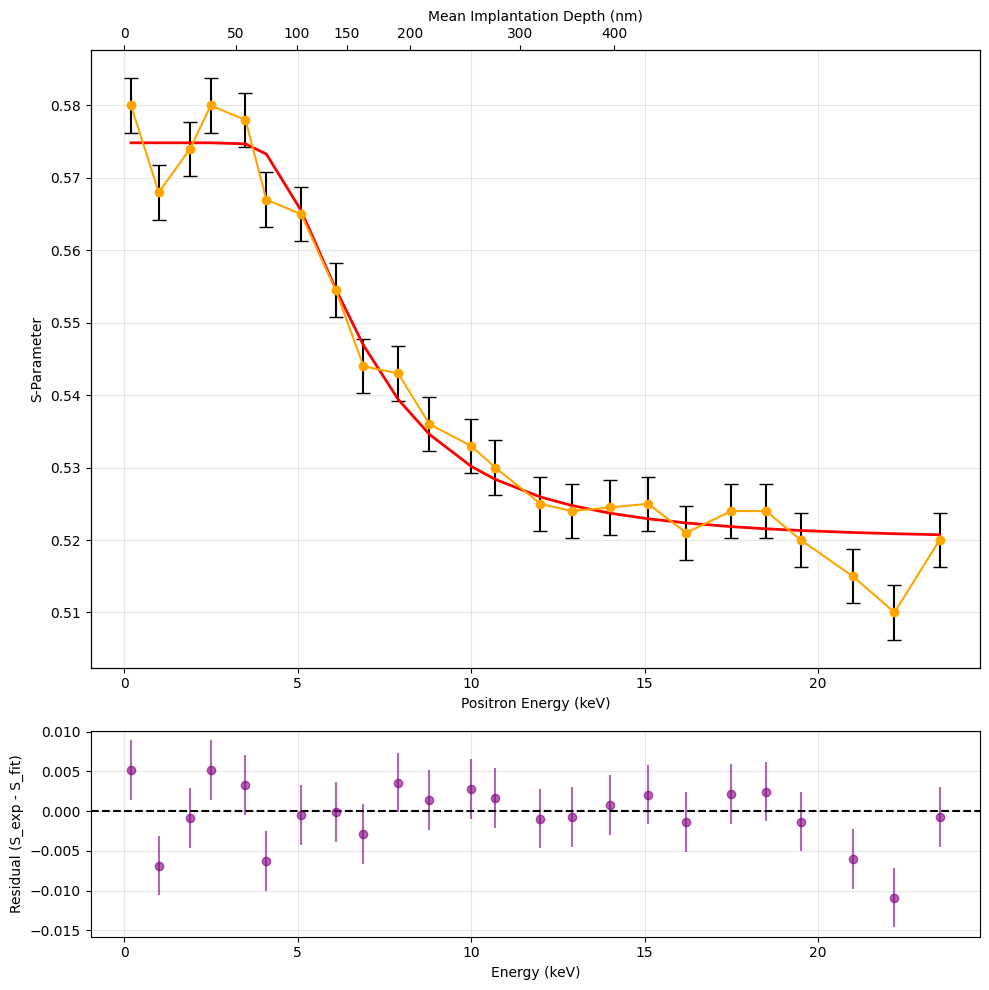

Result: Thickness = 156.07 nm, Oxide S = 0.5748


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1. YOUR DATA (S-parameter, Energy in keV)
# Re-organized to (Energy, S) for the solver
raw_data = [
    (0.58, 0.2), (0.568, 1), (0.574, 1.9), (0.58, 2.5), (0.578, 3.5),
    (0.5670, 4.1), (0.5650, 5.1), (0.5545, 6.1), (0.5440, 6.9), (0.5430, 7.9),
    (0.5360, 8.8), (0.5330, 10.0), (0.5300, 10.7), (0.5250, 12.0), (0.5240, 12.9),
    (0.5245, 14.0), (0.5250, 15.1), (0.5210, 16.2), (0.5240, 17.5), (0.5240, 18.5),
    (0.5200, 19.5), (0.5150, 21.0), (0.5100, 22.2), (0.5200, 23.5)
]
energies = np.array([x[1] for x in raw_data])
s_exp = np.array([x[0] for x in raw_data])
s_err = 0.00375 # Your provided error bars

# 2. PHYSICAL CONSTANTS
RHO_OX = 5.22    # Hematite density
RHO_SS = 8.00    # SS316L density
S_BULK_SS = 0.52 # Your baseline
A, n = 4.0, 1.6  # Makhov parameters

# 3. MAPPING FUNCTIONS
def get_mean_depth(E, d_ox):
    """Calculates z_bar using density-weighted path"""
    mass_cap = A * (E**n)
    ox_mass_limit = RHO_OX * d_ox * 0.1
    if mass_cap <= ox_mass_limit:
        return mass_cap / (RHO_OX * 0.1)
    else:
        return d_ox + (mass_cap - ox_mass_limit) / (RHO_SS * 0.1)

def model_func(E, d_ox, S_ox):
    """Makhov-based weighting model"""
    mass_cap = A * (E**n)
    ox_mass_limit = RHO_OX * d_ox * 0.1
    xi_0 = mass_cap / 0.886
    f_ox = 1 - np.exp(-(ox_mass_limit / xi_0)**2)
    return f_ox * S_ox + (1 - f_ox) * S_BULK_SS

# 4. SOLVER
popt, pcov = curve_fit(model_func, energies, s_exp, p0=[50, 0.58], sigma=np.full_like(s_exp, s_err))
d_ox_fit, S_ox_fit = popt
s_fit = model_func(energies, *popt)

# 5. PLOTTING
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

# --- Main Plot (Top) ---
ax1.errorbar(energies, s_exp, yerr=s_err, marker='o', color='orange', ecolor='black', label='Exp Data', capsize=5)
ax1.plot(energies, s_fit, 'r-', lw=2, label=f'Fit (d={d_ox_fit:.1f}nm)')
ax1.set_xlabel('Positron Energy (keV)')
ax1.set_ylabel('S-Parameter')
ax1.grid(True, alpha=0.3)

# Create the Depth Axis (Twin)
ax2 = ax1.twiny()
ax2.set_xlabel('Mean Implantation Depth (nm)')

# Map round depth numbers to energy positions for the top ticks
depth_ticks = np.array([0, 50, 100, 150, 200, 300, 400])
energy_tick_locs = []
for d in depth_ticks:
    limit = RHO_OX * d_ox_fit * 0.1
    m_cap = d*(RHO_OX*0.1) if d <= d_ox_fit else limit + (d-d_ox_fit)*(RHO_SS*0.1)
    energy_tick_locs.append((m_cap / A)**(1/n))

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(energy_tick_locs)
ax2.set_xticklabels([str(d) for d in depth_ticks])

# --- Residual Plot (Bottom) ---
ax3.errorbar(energies, s_exp - s_fit, yerr=s_err, fmt='o', color='purple', alpha=0.6)
ax3.axhline(0, color='black', linestyle='--')
ax3.set_xlabel('Energy (keV)')
ax3.set_ylabel('Residual (S_exp - S_fit)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Result: Thickness = {d_ox_fit:.2f} nm, Oxide S = {S_ox_fit:.4f}")